### Fusion of Features

In this notebook we will develop the pipeline for the fusion of extracted radiomics and deeply learnt features using the ACDC dataset. 

We will retake the pipeline used for the Radiomics supervised learning section of the project, but now we will add the deeply learnt features preprocessing and combination with radiomics. 

We will study predictive performance, feature selection and accuracy metrics either indidividually and combined.

In [1]:
### import the packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report, precision_score
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectKBest, f_classif, chi2, RFECV, RFE
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from skopt.space import Real, Integer
import pickle

### 1. Data Loading

In [2]:
###Radiomics

RF_df_train = pd.read_csv(r'C:\Users\alex1\Desktop\ACDC\Extracted_radiomics\ACDC_(Radiomics+Clinical)_Training.csv')
print(RF_df_train.shape)
RF_df_test = pd.read_csv(r'C:\Users\alex1\Desktop\ACDC\Extracted_radiomics\ACDC_(Radiomics+Clinical)_Testing.csv')
print(RF_df_test.shape)

(100, 777)
(50, 777)


In [3]:
RF_df_train = RF_df_train.loc[:,~ RF_df_train.columns.str.startswith('diagnostics')]
RF_df_test = RF_df_test.loc[:,~ RF_df_test.columns.str.startswith('diagnostics')]
print(RF_df_train.shape)
print(RF_df_test.shape)

(100, 645)
(50, 645)


Also, we separate the medical inputs and separate the independent variable (disease)

In [4]:
radiomics_train = RF_df_train.iloc[:,:-3]
med_info_train = RF_df_train.iloc[:,-3:-1]
y_train = RF_df_train.iloc[:,-1]

In [5]:
y_train.shape

(100,)

In [6]:
radiomics_test = RF_df_test.iloc[:,:-3]
med_info_test = RF_df_test.iloc[:,-3:-1]
y_test = RF_df_test.iloc[:,-1]

In [7]:
y_test.shape

(50,)

#### Deeply Learned Features

We load the Feeply Learned Features from their respective model to later be concatenated with the Radiomics and Medical Info

In [8]:

### Inception

path = r'Extracted_Features'

incep_DF_train_ED = pd.read_csv(path+'\Extracted_Features_IncepModel_train_ED.csv', header=None)
incep_DF_train_ES = pd.read_csv(path+'\Extracted_Features_IncepModel_train_ES.csv', header=None)
incep_DF_test_ED = pd.read_csv(path+'\Extracted_Features_IncepModel_test_ED.csv', header=None)
incep_DF_test_ES = pd.read_csv(path+'\Extracted_Features_IncepModel_test_ES.csv', header=None)

In [9]:
AlexNet_DF_train_ED = pd.read_csv(path+'\Extracted_Features_AlexNet_train_ED.csv', header=None)
AlexNet_DF_train_ES = pd.read_csv(path+'\Extracted_Features_AlexNet_train_ES.csv', header=None)
AlexNet_DF_test_ED = pd.read_csv(path+'\Extracted_Features_AlexNet_test_ED.csv', header=None)
AlexNet_DF_test_ES = pd.read_csv(path+'\Extracted_Features_AlexNet_test_ES.csv', header=None)

In [10]:
AlexNetdil_DF_train_ED = pd.read_csv(path+'\Extracted_Features_AlexNetDil_train_ED.csv', header=None)
AlexNetdil_DF_train_ES = pd.read_csv(path+'\Extracted_Features_AlexNetDil_train_ES.csv', header=None)
AlexNetdil_DF_test_ED = pd.read_csv(path+'\Extracted_Features_AlexNetDil_test_ED.csv', header=None)
AlexNetdil_DF_test_ES = pd.read_csv(path+'\Extracted_Features_AlexNetDil_test_ES.csv', header=None)

In [11]:
###################### We leave this out for the moments ############################
#VGG_DF_train = pd.read_csv(path+'\VGG_Extracted_Features_train.csv', header=None) ##
#VGG_DF_test = pd.read_csv(path+'\VGG_Extracted_Features_test.csv', header=None)   ##
####################################################################################

In [12]:
#Late Merging Model
LM_DF_train = pd.read_csv(path+'\LM_features_train.csv', header=None)
LM_DF_test_ES = pd.read_csv(path+'\LM_features_test_ES.csv', header=None)
LM_DF_test_ED = pd.read_csv(path+'\LM_features_test_ES.csv', header=None)

In [13]:
LM_DF_train.shape

(600, 256)

In [14]:
np_LM_train=np.asanyarray(LM_DF_train)
np_LM_train.shape

(600, 256)

In [15]:
def divide_LM_train():
    ED_list = list()
    ES_list = list()
    
    for i in np.arange(1,600,3):
        if (i % 2) == 0:
            ES_list.append(np_LM_train[i,:])
        else:
            ED_list.append(np_LM_train[i,:])
         
    ES = np.asanyarray(ES_list)
    ED = np.asanyarray(ED_list)

    return ES, ED 

In [16]:
ES, ED = divide_LM_train()

In [17]:
LM_train_ES = pd.DataFrame(ES)
LM_train_ED = pd.DataFrame(ED)

In [18]:
LM_DF_test_ES.shape

(50, 256)

In [1]:
def col_names(df, cycle):
    '''Function to add names to the deeply learned features
    to later be identified'''
    col_names= ['{}_dlf_{}'.format(cycle, x) for x in range(len(df.columns))]
    df.columns = col_names
    
    return df    

In [20]:
#### Creation of datasets
incep_DF_train_ED = col_names(incep_DF_train_ED, cycle='ED')
incep_DF_train_ES = col_names(incep_DF_train_ES, cycle='ES')

incep_DF_train = pd.concat([incep_DF_train_ED, incep_DF_train_ES], axis= 1)
incep_train_tot = pd.concat([incep_DF_train, med_info_train], axis=1)

incep_DF_test_ED = col_names(incep_DF_test_ED , cycle='ED')
incep_DF_test_ES = col_names(incep_DF_test_ES, cycle='ES')

incep_DF_test = pd.concat([incep_DF_test_ED, incep_DF_test_ES], axis= 1)
incep_test_tot = pd.concat([incep_DF_test, med_info_test], axis=1)

In [21]:
AlexNet_DF_train_ED = col_names(AlexNet_DF_train_ED, cycle='ED')
AlexNet_DF_train_ES = col_names(AlexNet_DF_train_ES, cycle= 'ES')

AlexNet_DF_train = pd.concat([AlexNet_DF_train_ED, AlexNet_DF_train_ES], axis= 1)
AlexNet_train_tot = pd.concat([AlexNet_DF_train, med_info_train], axis = 1)

AlexNet_DF_test_ED = col_names(AlexNet_DF_test_ED, cycle='ED')
AlexNet_DF_test_ES = col_names(AlexNet_DF_test_ES, cycle='ES')

AlexNet_DF_test = pd.concat([AlexNet_DF_test_ED, AlexNet_DF_test_ES], axis= 1)
AlexNet_test_tot = pd.concat([AlexNet_DF_test, med_info_test], axis = 1)

In [22]:
AlexNetdil_DF_train_ED = col_names(AlexNetdil_DF_train_ED, cycle='ED')
AlexNetdil_DF_train_ES = col_names(AlexNetdil_DF_train_ES, cycle= 'ES')

AlexNetdil_DF_train = pd.concat([AlexNetdil_DF_train_ED, AlexNetdil_DF_train_ES], axis= 1)
AlexNetdil_DF_train_tot = pd.concat([AlexNet_DF_train, med_info_train], axis= 1)

AlexNetdil_DF_test_ED = col_names(AlexNetdil_DF_test_ED, cycle='ED')
AlexNetdil_DF_test_ES = col_names(AlexNetdil_DF_test_ES, cycle='ES')

AlexNetdil_DF_test = pd.concat([AlexNetdil_DF_test_ED, AlexNetdil_DF_test_ES], axis= 1)
AlexNetdil_DF_test_tot = pd.concat([AlexNet_DF_test, med_info_test], axis= 1)

In [23]:
LM_train_ED = col_names(LM_train_ED, cycle='ED')
LM_train_ES = col_names(LM_train_ES, cycle='ES')

LM_train = pd.concat([LM_train_ED, LM_train_ES], axis=1)
LM_train_tot = pd.concat([LM_train, med_info_train], axis=1)

LM_DF_test_ED = col_names(LM_DF_test_ED, cycle='ED')
LM_DF_test_ES = col_names(LM_DF_test_ES, cycle='ES')

LM_test = pd.concat([LM_DF_test_ED, LM_DF_test_ES], axis=1)
LM_test_tot = pd.concat([LM_test, med_info_test], axis=1)

In [24]:
VGG_DF_train = col_names(VGG_DF_train)
VGG_DF_test = col_names(VGG_DF_test)

### 2. Fusion of Features and data processing

In this section we combine both data modalities in a single data frame. Also, we will be performing the necessary scale for the dataset

In [25]:
class testing_model:
    def __init__(self, data1, data2, data3, data4):
        self.train1 = data1
        self.train2 = data2
        self.test1 = data3
        self.test2 = data4
        
    def concatenate(self):
        X_train = pd.concat([self.train1, self.train2], axis=1)
        X_test = pd.concat([self.test1, self.test2], axis = 1)
        
        return X_train, X_test

In [27]:
def processing(X_train,y_train, X_test, y_test):
    #tools scaling and labelling
    scaler = MinMaxScaler()
    encoder = LabelEncoder()
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    y_train = encoder.fit_transform(y_train)
    y_test = encoder.fit_transform(y_test)
    
    return X_train, y_train, X_test, y_test

### 3. Machine Learning

- prueba 1 = Radiomics + ED
- prueba 2 = Radiomics + ES
- prueba 3 = Radiomics + ES + ED
- prubea 4 = Radiomics + ES + ED + Med

#### Grid Search K-Best

In [29]:
def KBest_GS(X_train, y_train, X_test, y_test, model, param_grid, df):
    
    featss =np.arange(3,X_train.shape[1],1)
    
    selector = SelectKBest()
    
    ### Pipeline
    
    ### we would need to adapt the "NUMBER OF FEATURES PARAMETER OF THE GRID"
    
    pipe = Pipeline([('selector', selector), 
                 ('model', model)])
    
    dict_1 = {'selector__score_func': [f_classif],
              'selector__k':featss}   #### para pruebas
    
    dict_1.update(param_grid)
    
    gs = GridSearchCV(estimator=pipe, 
                  param_grid=dict_1, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=StratifiedKFold(2, shuffle=True, random_state=42),
                  iid=True,
                  refit=True,
                verbose=0)
    
    print(pipe.get_params().keys())
    
    gs = gs.fit(X_train, y_train)
    
    print("Best Model", gs.best_params_)
    
    print('Best score:', gs.best_score_)
    
    y_test_pred = gs.predict(X_test)
    
    test_acc = accuracy_score(y_test,y_test_pred)
    
    print("\n Test Accuracy with best estimator: ", test_acc)
    
    cm = confusion_matrix(y_test, y_test_pred)
        
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,4))
    
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.tight_layout()

    class_list = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks, class_list, rotation=45)
    plt.yticks(tick_marks, class_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test, y_test_pred,target_names=class_list))
    
    cols = gs.best_estimator_.steps[0][1].get_support(indices=True)
    print(df.iloc[:,cols].columns)
    
    
    return gs
    

--- 
#### Grid Search Sequential Forward Elimination

In [55]:
def SFS_GS(X_train, y_train, X_test, y_test, model, param_grid, df):
    
    #Setting up the SFS
    sfs1 = SFS(estimator=model, 
           k_features=X_train.shape[1],
           forward=True, 
           floating=False, 
           scoring='accuracy',
           cv=StratifiedKFold(4, shuffle=True, random_state=42))
    
    ### Pipeline
    
    ### we would need to adapt the "NUMBER OF FEATURES PARAMETER OF THE GRID"
    
    pipe = Pipeline([('sfs', sfs1), 
                 ('model', model)])
    
    #dict_1 = {'sfs__k_features':list(range(1,X_train.shape[1]))}   #### para pruebas
    
    dict_1 = {'sfs__k_features':[5,6,10,15]}  #pruebas
    
    dict_1.update(param_grid)
    
    gs = GridSearchCV(estimator=pipe, 
                  param_grid=dict_1, 
                  scoring='accuracy', 
                  n_jobs=1, 
                  cv=StratifiedKFold(4, shuffle=True, random_state=42),
                  verbose=3,
                  refit=True)
    
#     print(pipe.get_params().keys())
    
    gs = gs.fit(X_train, y_train)
    
#     print(gs.best_estimator_.steps)
    
    print("Best Model", gs.best_params_)
    
#     print('Best score:', gs.best_score_)
    
    y_test_pred = gs.predict(X_test)
    
    test_acc = accuracy_score(y_test,y_test_pred)
    
    print("\n Test Accuracy with best estimator: ", test_acc)
    
    cm = confusion_matrix(y_test, y_test_pred)
        
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8,4))
    
    plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    plt.tight_layout()

    class_list = ['DCM', 'HCM', 'MINF', 'NOR', 'RV']

    tick_marks = np.arange(len(class_list))
    plt.xticks(tick_marks, class_list, rotation=45)
    plt.yticks(tick_marks, class_list)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    print(classification_report(y_test, y_test_pred,target_names=class_list))
    
    feats = gs.best_estimator_.steps[0][1].k_feature_idx_
    
    feats_2= np.asanyarray(feats)
    
    print(df.iloc[:,feats_2].columns)
    
    return gs, pipe
    

In [52]:
#Support Vector Classifier

model_SVC = SVC(gamma = 'scale', max_iter= 5000, random_state=42)

param_grid_SVC =  {'model__C':[5, 10],
                   'model__kernel':('linear', 'rbf')
                   }

param_grid_SVC_nested_2 =  { 'selector__estimator__kernel': ['linear', 'rbf'],
                   'selector__estimator__C':[15]}

param_grid_SVC_test_2 =  { 
                   'estimator__model__C':[0.5, 1,5,10]}

In [82]:
X_train, y_train = processing(X_train_df, y_train)
X_test, y_test = processing(X_test_df, y_test)

In [83]:
X_train.shape

(100, 2690)

In [19]:
featss =np.asanyarray(range(1,X_train.shape[1]))

--- 
#### Using the features extracted from the Inception

In [226]:
X_train1, X_test1 = testing_model(radiomics_train, incep_DF_train_ED, radiomics_test, incep_DF_test_ED).concatenate()
X_train2, X_test2 = testing_model(radiomics_train, incep_DF_train_ES, radiomics_test, incep_DF_test_ES).concatenate()
X_train3, X_test3 = testing_model(radiomics_train, incep_DF_train, radiomics_test, incep_DF_test).concatenate()
X_train4, X_test4 = testing_model(radiomics_train, incep_train_tot, radiomics_test, incep_test_tot).concatenate()

In [228]:
X_train_1, y_train = processing(X_train1, y_train)
X_test_1, y_test = processing(X_test1, y_test)

In [230]:
X_train_2, y_train = processing(X_train2, y_train)
X_test_2, y_test = processing(X_test2, y_test)

In [232]:
X_train_3, y_train = processing(X_train3, y_train)
X_test_3, y_test = processing(X_test3, y_test)

In [235]:
X_train_4, y_train = processing(X_train4, y_train)
X_test_4, y_test = processing(X_test4, y_test)

dict_keys(['memory', 'steps', 'verbose', 'selector', 'model', 'selector__k', 'selector__score_func', 'model__C', 'model__cache_size', 'model__class_weight', 'model__coef0', 'model__decision_function_shape', 'model__degree', 'model__gamma', 'model__kernel', 'model__max_iter', 'model__probability', 'model__random_state', 'model__shrinking', 'model__tol', 'model__verbose'])
Best Model {'model__C': 1, 'model__kernel': 'linear', 'selector__k': 141, 'selector__score_func': <function f_classif at 0x0000021DE7E22B88>}
Best score: 0.97

 Test Accuracy with best estimator:  0.82


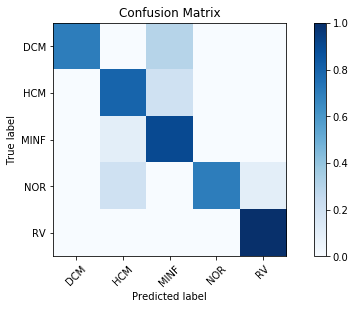

              precision    recall  f1-score   support

         DCM       1.00      0.70      0.82        10
         HCM       0.73      0.80      0.76        10
        MINF       0.64      0.90      0.75        10
         NOR       1.00      0.70      0.82        10
          RV       0.91      1.00      0.95        10

    accuracy                           0.82        50
   macro avg       0.86      0.82      0.82        50
weighted avg       0.86      0.82      0.82        50

Index(['ED_dlf_964', 'ES_dlf_3', 'ES_dlf_42', 'ES_dlf_68', 'ES_dlf_76',
       'ES_dlf_84', 'ES_dlf_85', 'ES_dlf_87', 'ES_dlf_88', 'ES_dlf_89',
       ...
       'ES_dlf_1930', 'ES_dlf_1931', 'ES_dlf_1935', 'ES_dlf_1955',
       'ES_dlf_1964', 'ES_dlf_1967', 'ES_dlf_1987', 'ES_dlf_2003',
       'ES_dlf_2006', 'ES_dlf_2047'],
      dtype='object', length=141)


In [236]:
gs = KBest_GS(X_train_4, y_train, X_test_4, y_test, model_SVC, param_grid_SVC, X_train4)

--- 
#### Using the features extracted from the AlexNet

In [36]:
X_train1, X_test1 = testing_model(radiomics_train, AlexNet_DF_train_ED, radiomics_test, AlexNet_DF_test_ED).concatenate()
X_train2, X_test2 = testing_model(radiomics_train, AlexNet_DF_train_ES, radiomics_test, AlexNet_DF_test_ES).concatenate()
X_train3, X_test3 = testing_model(radiomics_train, AlexNet_DF_train, radiomics_test, AlexNet_DF_test).concatenate()
X_train4, X_test4 = testing_model(radiomics_train, AlexNet_train_tot, radiomics_test, AlexNet_test_tot).concatenate()

In [37]:
X_train_1, y_train, X_test_1, y_test = processing(X_train1, y_train, X_test1, y_test)


In [41]:
X_train_2, y_train, X_test_2, y_test = processing(X_train2, y_train, X_test2, y_test)


In [247]:
X_train_3, y_train = processing(X_train3, y_train)
X_test_3, y_test = processing(X_test3, y_test)

In [248]:
X_train_4, y_train = processing(X_train4, y_train)
X_test_4, y_test = processing(X_test4, y_test)

In [249]:
X_train1.shape

(100, 647)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
[CV] model__C=5, model__kernel=linear, sfs__k_features=5 .............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__C=5, model__kernel=linear, sfs__k_features=5, score=0.920, total=  14.5s
[CV] model__C=5, model__kernel=linear, sfs__k_features=5 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.4s remaining:    0.0s


[CV]  model__C=5, model__kernel=linear, sfs__k_features=5, score=0.960, total=  13.1s
[CV] model__C=5, model__kernel=linear, sfs__k_features=5 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   27.5s remaining:    0.0s


[CV]  model__C=5, model__kernel=linear, sfs__k_features=5, score=0.920, total=  13.0s
[CV] model__C=5, model__kernel=linear, sfs__k_features=5 .............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=5, score=0.920, total=  12.9s
[CV] model__C=5, model__kernel=linear, sfs__k_features=6 .............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=6, score=0.880, total=  15.8s
[CV] model__C=5, model__kernel=linear, sfs__k_features=6 .............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=6, score=0.960, total=  16.5s
[CV] model__C=5, model__kernel=linear, sfs__k_features=6 .............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=6, score=0.880, total=  16.2s
[CV] model__C=5, model__kernel=linear, sfs__k_features=6 .............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=6, score=0.920, total=  15.8s
[CV] model__C=5, model__kernel=linear, sfs__k_features=10 ............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=10

[CV]  model__C=10, model__kernel=rbf, sfs__k_features=6, score=0.920, total=  17.8s
[CV] model__C=10, model__kernel=rbf, sfs__k_features=10 ..............
[CV]  model__C=10, model__kernel=rbf, sfs__k_features=10, score=0.920, total=  29.7s
[CV] model__C=10, model__kernel=rbf, sfs__k_features=10 ..............
[CV]  model__C=10, model__kernel=rbf, sfs__k_features=10, score=0.880, total=  27.9s
[CV] model__C=10, model__kernel=rbf, sfs__k_features=10 ..............
[CV]  model__C=10, model__kernel=rbf, sfs__k_features=10, score=0.840, total=  30.4s
[CV] model__C=10, model__kernel=rbf, sfs__k_features=10 ..............
[CV]  model__C=10, model__kernel=rbf, sfs__k_features=10, score=0.960, total=  29.5s
[CV] model__C=10, model__kernel=rbf, sfs__k_features=15 ..............
[CV]  model__C=10, model__kernel=rbf, sfs__k_features=15, score=0.880, total=  44.6s
[CV] model__C=10, model__kernel=rbf, sfs__k_features=15 ..............
[CV]  model__C=10, model__kernel=rbf, sfs__k_features=15, score=0

[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed: 27.2min finished


Best Model {'model__C': 5, 'model__kernel': 'linear', 'sfs__k_features': 5}

 Test Accuracy with best estimator:  0.82


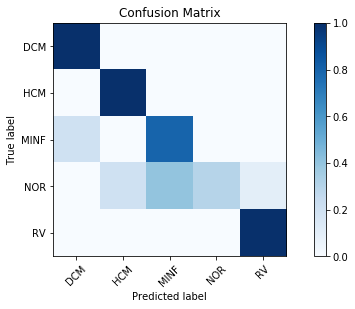

              precision    recall  f1-score   support

         DCM       0.83      1.00      0.91        10
         HCM       0.83      1.00      0.91        10
        MINF       0.67      0.80      0.73        10
         NOR       1.00      0.30      0.46        10
          RV       0.91      1.00      0.95        10

    accuracy                           0.82        50
   macro avg       0.85      0.82      0.79        50
weighted avg       0.85      0.82      0.79        50

Index(['original_glrlm_ShortRunHighGrayLevelEmphasis_LV_ES',
       'original_glszm_SizeZoneNonUniformityNormalized_LV_ES', 'ES_dlf_0',
       'ES_dlf_2', 'ES_dlf_3'],
      dtype='object')


In [57]:
gs, pipe = SFS_GS(X_train_2, y_train, X_test_2, y_test, model_SVC, param_grid_SVC, X_train2)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=5 ...........


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=5, score=0.840, total=  15.2s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=5 ...........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s remaining:    0.0s


[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=5, score=0.880, total=  15.1s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=5 ...........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   30.2s remaining:    0.0s


[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=5, score=0.760, total=  14.3s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=5 ...........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=5, score=0.760, total=  14.7s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=10 ..........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=10, score=0.880, total=  31.1s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=10 ..........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=10, score=0.880, total=  30.9s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=10 ..........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=10, score=0.760, total=  32.1s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=10 ..........
[CV]  model__C=0.5, model__kernel=linear, sfs__k_features=10, score=0.800, total=  31.6s
[CV] model__C=0.5, model__kernel=linear, sfs__k_features=15 ..........
[CV]  model__C=0.5, model__kernel=linear, 

[CV]  model__C=5, model__kernel=linear, sfs__k_features=10, score=0.920, total=  30.0s
[CV] model__C=5, model__kernel=linear, sfs__k_features=15 ............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=15, score=0.880, total=  45.9s
[CV] model__C=5, model__kernel=linear, sfs__k_features=15 ............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=15, score=0.920, total=  45.2s
[CV] model__C=5, model__kernel=linear, sfs__k_features=15 ............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=15, score=0.920, total=  46.6s
[CV] model__C=5, model__kernel=linear, sfs__k_features=15 ............
[CV]  model__C=5, model__kernel=linear, sfs__k_features=15, score=0.880, total=  48.4s
[CV] model__C=5, model__kernel=rbf, sfs__k_features=5 ................
[CV]  model__C=5, model__kernel=rbf, sfs__k_features=5, score=0.920, total=  16.5s
[CV] model__C=5, model__kernel=rbf, sfs__k_features=5 ................
[CV]  model__C=5, model__kernel=rbf, sfs__k_features=5, 

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed: 49.1min finished


Best Model {'model__C': 5, 'model__kernel': 'linear', 'sfs__k_features': 5}

 Test Accuracy with best estimator:  0.9


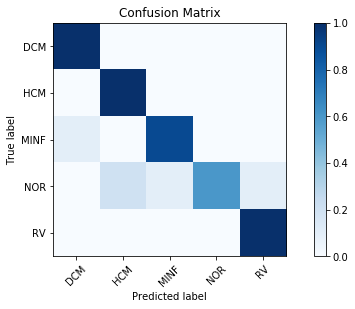

              precision    recall  f1-score   support

         DCM       0.91      1.00      0.95        10
         HCM       0.83      1.00      0.91        10
        MINF       0.90      0.90      0.90        10
         NOR       1.00      0.60      0.75        10
          RV       0.91      1.00      0.95        10

    accuracy                           0.90        50
   macro avg       0.91      0.90      0.89        50
weighted avg       0.91      0.90      0.89        50

Index(['original_glrlm_ShortRunHighGrayLevelEmphasis_LV_ES',
       'original_glszm_SizeZoneNonUniformityNormalized_LV_ES', 'ES_dlf_0',
       'ES_dlf_2', 'ES_dlf_3'],
      dtype='object')


In [261]:
#gs, pipe = SFS_GS(X_train_4, y_train, X_test_4, y_test, model_SVC, param_grid_SVC, X_train4)

In [56]:
gs = KBest_GS(X_train_2, y_train, X_test_2, y_test, model_SVC, param_grid_SVC, X_train2)

dict_keys(['memory', 'steps', 'verbose', 'selector', 'model', 'selector__k', 'selector__score_func', 'model__C', 'model__cache_size', 'model__class_weight', 'model__coef0', 'model__decision_function_shape', 'model__degree', 'model__gamma', 'model__kernel', 'model__max_iter', 'model__probability', 'model__random_state', 'model__shrinking', 'model__tol', 'model__verbose'])


KeyboardInterrupt: 

--- 
#### Using the features extracted from the VGG

In [324]:
X_train_df_3 = pd.concat([radiomics_train, VGG_DF_train], axis=1)
X_test_df_3 = pd.concat([radiomics_test, VGG_DF_test], axis=1)

In [325]:
X_train, y_train = processing(X_train_df_3, y_train)
X_test, y_test = processing(X_test_df_3, y_test)

--- 
#### Using the features extracted from the AlexNetDil

In [175]:
X_train1, X_test1 = testing_model(radiomics_train, AlexNetdil_DF_train_ED, radiomics_test, AlexNetdil_DF_test_ED).concatenate()
X_train2, X_test2 = testing_model(radiomics_train, AlexNetdil_DF_train_ES, radiomics_test, AlexNetdil_DF_test_ES).concatenate()
X_train3, X_test3 = testing_model(radiomics_train, AlexNetdil_DF_train, radiomics_test, AlexNetdil_DF_test).concatenate()
X_train4, X_test4 = testing_model(radiomics_train, AlexNetdil_DF_train_tot, radiomics_test, AlexNetdil_DF_test_tot).concatenate()

In [215]:
X_train1.shape

(100, 898)

--- 
#### Using the features extracted from the Late Merging Model

In [262]:
X_train1, X_test1 = testing_model(radiomics_train, LM_train_ED, radiomics_test, LM_DF_test_ED).concatenate()
X_train2, X_test2 = testing_model(radiomics_train, LM_train_ES, radiomics_test, LM_DF_test_ES).concatenate()
X_train3, X_test3 = testing_model(radiomics_train, LM_train, radiomics_test, LM_test).concatenate()
X_train4, X_test4 = testing_model(radiomics_train, LM_train_tot, radiomics_test, LM_test_tot).concatenate()

In [263]:
X_train_1, y_train = processing(X_train1, y_train)
X_test_1, y_test = processing(X_test1, y_test)

In [264]:
X_train_2, y_train = processing(X_train2, y_train)
X_test_2, y_test = processing(X_test2, y_test)

In [265]:
X_train_3, y_train = processing(X_train3, y_train)
X_test_3, y_test = processing(X_test3, y_test)

In [266]:
X_train_4, y_train = processing(X_train4, y_train)
X_test_4, y_test = processing(X_test4, y_test)

In [ ]:
#gs = KBest_GS(X_train_2, y_train, X_test_2, y_test, model_SVC, param_grid_SVC, X_train2)